In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd

In [6]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [7]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [8]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Inspect data
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [13]:
column_m = inspector.get_columns('measurement')
for c in column_m:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [14]:
column_s = inspector.get_columns('station')
for c in column_s:
    print(c["name"], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
session = Session(engine)

In [16]:
# Get earliest date
# reference to each table measurement >> Measurement and station >> Station
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

In [17]:
# latest date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [18]:
year_ago = dt.date(2017, 8 ,23) - dt.timedelta(days=365)
print(year_ago)

2016-08-23


# Exploratory Climate Analysis

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [20]:
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017, 8 ,23) - dt.timedelta(days=365)
print(year_ago)

2016-08-23


In [21]:
# Perform a query to retrieve the data and precipitation scores
precipitation_1year = session.query(Measurement.date, Measurement.prcp).\
                      filter(Measurement.date >= year_ago ).\
                      order_by(Measurement.date)

In [22]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_1year_df = pd.DataFrame(precipitation_1year, columns = ['Date','Precipitation'])
precipitation_1year_df.head()

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


In [23]:
precipitation_1year_df = precipitation_1year_df.dropna()

In [24]:
precipitation_1year_df.count()

Date             2021
Precipitation    2021
dtype: int64

In [25]:
# Sort the dataframe by date
precipitation_1year_df.head()
ordered_precipitation_1year_df = precipitation_1year_df.sort_values(["Date"], ascending=False)

In [26]:
ordered_precipitation_1year_df.count()

Date             2021
Precipitation    2021
dtype: int64

In [27]:
type(precipitation_1year_df)

pandas.core.frame.DataFrame

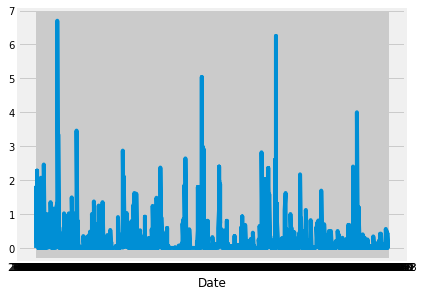

In [28]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(precipitation_1year_df["Date"],precipitation_1year_df["Precipitation"])
plt.tight_layout()
plt.xlabel("Date")
plt.grid
plt.show()

In [29]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_1year_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [30]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(Station.station).count()
total_stations

9

In [31]:
# What are the most active stations? (i.e. what stations have the most rows)?
station_activity = session.query(Measurement.station, func.count(Measurement.tobs))\
             .group_by(Measurement.station)\
             .order_by(func.count(Measurement.tobs).desc())

In [32]:
# List the stations and the counts in descending order.
for station in station_activity:
    print(station)
    
# Storing station name
top_station = station_activity[0][0]

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [33]:
most_active_station = session.query(Measurement.station, func.count(Measurement.tobs))\
             .group_by(Measurement.station)\
             .order_by(func.count(Measurement.tobs).desc()).first()
for station in most_active_station:
    print(station)

USC00519281
2772


In [34]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


In [35]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
oneYear_Stations = session.query(Measurement.station, Station.name, func.count(Measurement.tobs)).\
                    filter(Measurement.station == Station.station).\
                    group_by(Measurement.station).\
                    filter(Measurement.date > year_ago).\
                    order_by(func.count(Measurement.tobs).desc()).all()
oneYear_Stations

[('USC00519397', 'WAIKIKI 717.2, HI US', 360),
 ('USC00519281', 'WAIHEE 837.5, HI US', 351),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 348),
 ('USC00513117', 'KANEOHE 838.1, HI US', 342),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 336),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 304),
 ('USC00517948', 'PEARL CITY, HI US', 182)]

In [36]:
# Which station has the highest number of observations?
a_oneYear_Stations = session.query(Measurement.station, Station.name, func.count(Measurement.tobs)).\
                    filter(Measurement.station == Station.station).\
                    group_by(Measurement.station).\
                    filter(Measurement.date > year_ago).\
                    order_by(func.count(Measurement.tobs).desc()).first()
a_oneYear_Stations

('USC00519397', 'WAIKIKI 717.2, HI US', 360)

In [37]:
busiest_station = oneYear_Stations[0][0:2] 
highest_obs = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == busiest_station[0]).\
    filter(Measurement.date > year_ago).\
    order_by(Measurement.date).all()

#DataFrame. 
highest_obs_df = pd.DataFrame(highest_obs, columns=['Date', 'Tobs'])
highest_obs_df.head()

,Date,Tobs
0,2016-08-24,79.0
1,2016-08-25,80.0
2,2016-08-26,79.0
3,2016-08-27,77.0
4,2016-08-28,78.0


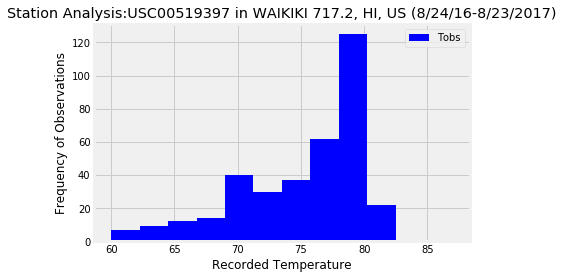

In [38]:
# Plot the resoults as a hsitogram with bins=12
plt.hist(highest_obs_df['Tobs'], bins=12, color = 'blue')
plt.rcParams['figure.figsize'] = [10,6]
plt.xlabel('Recorded Temperature')
plt.ylabel('Frequency of Observations')
plt.title("Station Analysis:USC00519397 in WAIKIKI 717.2, HI, US (8/24/16-8/23/2017)")
plt.legend(['Tobs'])
plt.savefig("Images/Station_Analysis.png")
plt.show()

In [40]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [47]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = ("2017-03-01" , "2017-03-15")
trip_temps = calc_temps(trip[0],trip[1])
trip_temps

[(62.0, 71.1086956521739, 82.0)]

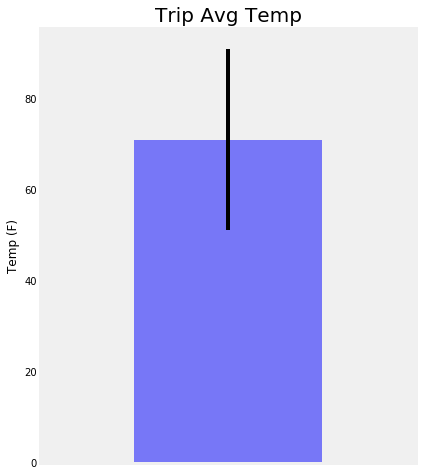

In [57]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(trip_temps, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
tmax_tmin = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=tmax_tmin, figsize=(6,8), alpha=0.5, color='blue')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.show()

In [68]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_rainfall_station = session.query(Station.station,
                  func.sum(Measurement.prcp),
                  Station.name,
                  Station.elevation,                                    
                  Station.latitude,
                  Station.longitude)\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= trip[0] )\
.filter(Measurement.date <= trip[1])\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc())

print()
print (f"Total amount of rainfall per weather station \n Trip Dates: \ {trip[0]} - {trip[1]}")
print()
for station in total_rainfall_station:
    prcp="{0:.2f}".format(row[1])
    print (f"Station:  {row[0]}\n    Rainfall:  {prcp}  \n    Location:  {row[2]}\n    Elevation:  {row[3]}  \
    Latitude:  {row[4]}  Longitude:  {row[5]}")
    print()


Total amount of rainfall per weather station 
 Trip Dates: \ 2017-03-01 - 2017-03-15

Station:  USC00514830
    Rainfall:  1.75  
    Location:  KUALOA RANCH HEADQUARTERS 886.9, HI US
    Elevation:  7.0      Latitude:  21.5213  Longitude:  -157.8374

Station:  USC00514830
    Rainfall:  1.75  
    Location:  KUALOA RANCH HEADQUARTERS 886.9, HI US
    Elevation:  7.0      Latitude:  21.5213  Longitude:  -157.8374

Station:  USC00514830
    Rainfall:  1.75  
    Location:  KUALOA RANCH HEADQUARTERS 886.9, HI US
    Elevation:  7.0      Latitude:  21.5213  Longitude:  -157.8374

Station:  USC00514830
    Rainfall:  1.75  
    Location:  KUALOA RANCH HEADQUARTERS 886.9, HI US
    Elevation:  7.0      Latitude:  21.5213  Longitude:  -157.8374

Station:  USC00514830
    Rainfall:  1.75  
    Location:  KUALOA RANCH HEADQUARTERS 886.9, HI US
    Elevation:  7.0      Latitude:  21.5213  Longitude:  -157.8374

Station:  USC00514830
    Rainfall:  1.75  
    Location:  KUALOA RANCH HEADQUARTER

# Step 2 - Climate App

In [ ]:
# Now that you have completed your initial analysis, design a Flask API based on the queries that you have just developed.
# Use FLASK to create your routes.

In [5]:
from flask import Flask, json, jsonify


app = Flask(__name__)


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
